In [ ]:
!pip install yfinance --quiet
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
# Tickers and date range
tickers = [
    'AAPL', 'MSFT', 'NVDA', 'AMZN', 'GOOGL',
    'META', 'TSLA', 'BRK-B', 'JPM', 'V',
    'SAP.DE', 'SIE.DE', 'ALV.DE', 'VOW3.DE', 'LIN.DE',
    'MC.PA', 'OR.PA', 'AIR.PA', 'ASML.AS', 'NESN.SW'
]
start_date = '2010-01-01'
end_date = '2025-03-31'

# Download data
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)


[*********************100%***********************]  20 of 20 completed


In [ ]:
#Step 3: Feature engineering (returns, volatility, lagged returns, dollar volume, target)
def preprocess_data(data, tickers, lookback=5, horizon=5):
    processed = {}
    for ticker in tickers:
        if ticker in data:
            df = data[ticker].copy()
            if isinstance(df.index, pd.DatetimeIndex):
                df.index = df.index.tz_localize(None)

            df['Return'] = df['Close'].pct_change()
            df['Volatility'] = df['Return'].rolling(21).std()
            df['DollarVolume'] = (df['Close'] * df['Volume']).rolling(5).mean()

            # Lag features
            for lag in range(1, lookback + 1):
                df[f'Return_lag_{lag}'] = df['Return'].shift(lag)

            # Target
            df['Target'] = df['Close'].pct_change(horizon).shift(-horizon)

            df = df.dropna()
            if len(df) > 100:
                processed[ticker] = df

    return processed

processed_data = preprocess_data(data, tickers)


/tmp/ipython-input-5-3932448313.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()
/tmp/ipython-input-5-3932448313.py:19: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Target'] = df['Close'].pct_change(horizon).shift(-horizon)
/tmp/ipython-input-5-3932448313.py:10: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Return'] = df['Close'].pct_change()
/tmp/

In [ ]:
#Sequence preparation for RNN input
from sklearn.preprocessing import RobustScaler

def create_rnn_sequences(df, feature_cols, target_col, sequence_length=10):
    X, y = [], []
    scaler = RobustScaler()
    features_scaled = scaler.fit_transform(df[feature_cols])

    for i in range(sequence_length, len(df)):
        X.append(features_scaled[i-sequence_length:i])
        y.append(df[target_col].iloc[i])

    return np.array(X), np.array(y), scaler


In [ ]:
# Define and train the RNN model per stock
def train_rnn_models(processed_data, sequence_length=10, epochs=50, batch_size=32):
    all_results = {}
    metrics_summary = []

    for ticker, df in processed_data.items():
        print(f"\n📈 Training RNN for {ticker}...")

        # Select features (same logic as before)
        feature_cols = [col for col in df.columns if col.startswith(('Return', 'Volatility', 'Dollar')) and 'lag' not in col]
        target_col = 'Target'

        # Create RNN sequences
        X, y, scaler = create_rnn_sequences(df, feature_cols, target_col, sequence_length)

        # Train-test split: last 20% for testing
        split_idx = int(len(X) * 0.8)
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]

        # Define model
        model = Sequential()
        model.add(SimpleRNN(32, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
        model.add(Dense(1))
        model.compile(loss='mse', optimizer='adam')

        # Train
        model.fit(X_train, y_train,
                  validation_split=0.1,
                  epochs=epochs,
                  batch_size=batch_size,
                  verbose=0,
                  callbacks=[EarlyStopping(patience=5, restore_best_weights=True)])

        # Predict
        preds = model.predict(X_test).flatten()
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        metrics_summary.append({
            'Ticker': ticker,
            'MAE': mae,
            'RMSE': rmse
        })

        all_results[ticker] = {
            'model': model,
            'scaler': scaler,
            'X_test': X_test,
            'y_test': y_test,
            'preds': preds
        }

    return all_results, pd.DataFrame(metrics_summary)


In [ ]:
rnn_results, rnn_metrics = train_rnn_models(processed_data)



📈 Training RNN for AAPL...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

📈 Training RNN for MSFT...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📈 Training RNN for NVDA...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📈 Training RNN for AMZN...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

📈 Training RNN for GOOGL...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

📈 Training RNN for META...
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

📈 Training RNN for TSLA...
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

📈 Training RNN for BRK-B...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

📈 Training RNN for JPM...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

📈 Training RNN for V...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

📈 Training RNN for SAP.DE...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📈 Training RNN for SIE.DE...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📈 Training RNN for ALV.DE...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

📈 Training RNN for VOW3.DE...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📈 Training RNN for LIN.DE...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

📈 Training RNN for MC.PA...
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

📈 Training RNN for OR.PA...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📈 Training RNN for AIR.PA...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

📈 Training RNN for ASML.AS...
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📈

In [ ]:
# Display summary table sorted by RMSE
rnn_metrics_sorted = rnn_metrics.sort_values(by='RMSE').reset_index(drop=True)
display(rnn_metrics_sorted)


,Ticker,MAE,RMSE
0,NESN.SW,0.019928,0.026696
1,ALV.DE,0.024344,0.033150
2,V,0.025758,0.034514
3,SAP.DE,0.029036,0.036917
4,OR.PA,0.028808,0.037148
5,BRK-B,0.028442,0.037492
6,LIN.DE,0.023532,0.039090
7,VOW3.DE,0.034382,0.044247
8,AIR.PA,0.031832,0.044265
9,MC.PA,0.035611,0.046050


In [ ]:
# Compute average metrics if needed
avg_mae = rnn_metrics['MAE'].mean()
avg_rmse = rnn_metrics['RMSE'].mean()

# Add as a new row at the bottom
avg_row = pd.DataFrame([{'Ticker': 'AVG_ALL', 'MAE': avg_mae, 'RMSE': avg_rmse}])
rnn_metrics = pd.concat([rnn_metrics, avg_row], ignore_index=True)

# Display again
display(rnn_metrics)


,Ticker,MAE,RMSE
0,AAPL,0.036272,0.046802
1,MSFT,0.053271,0.070908
2,NVDA,0.198829,0.261653
3,AMZN,0.043480,0.060575
4,GOOGL,0.038531,0.050411
5,META,0.050284,0.071476
6,TSLA,0.088411,0.111553
7,BRK-B,0.028442,0.037492
8,JPM,0.038502,0.053258
9,V,0.025758,0.034514


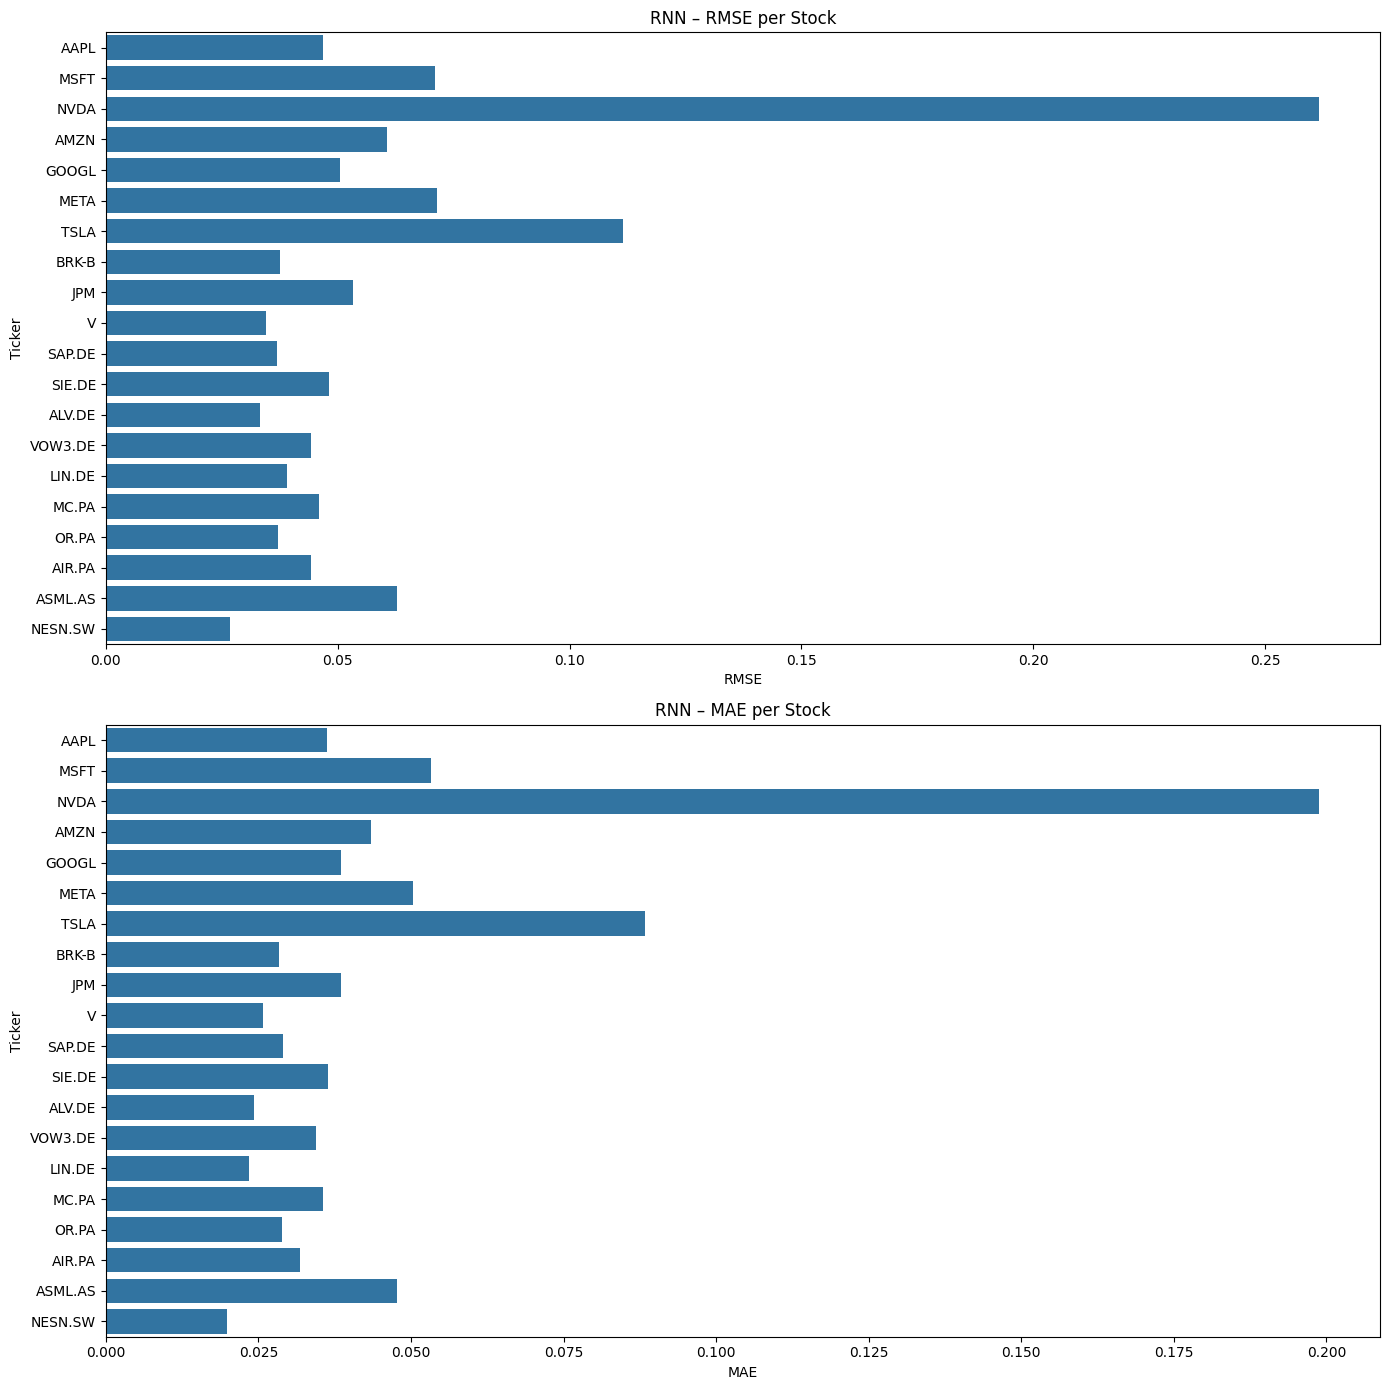

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out any potential 'AVG_ALL' if added later
plot_data = rnn_metrics[rnn_metrics['Ticker'] != 'AVG_ALL']

fig, axs = plt.subplots(2, 1, figsize=(14, 14))

sns.barplot(x='RMSE', y='Ticker', data=plot_data, ax=axs[0])
axs[0].set_title('RNN – RMSE per Stock')

sns.barplot(x='MAE', y='Ticker', data=plot_data, ax=axs[1])
axs[1].set_title('RNN – MAE per Stock')

plt.tight_layout()
plt.show()


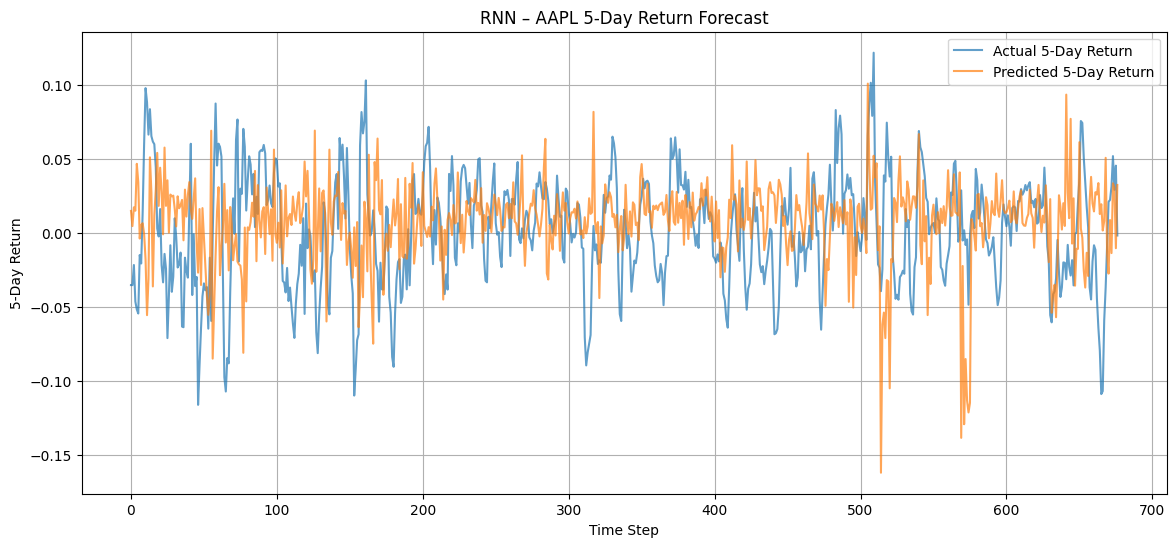

In [ ]:
def plot_rnn_predictions(ticker, results):
    if ticker not in results:
        print(f"{ticker} not found in RNN results.")
        return

    result = results[ticker]
    y_test = result['y_test']
    preds = result['preds']

    plt.figure(figsize=(14, 6))
    plt.plot(range(len(y_test)), y_test, label='Actual 5-Day Return', alpha=0.7)
    plt.plot(range(len(preds)), preds, label='Predicted 5-Day Return', alpha=0.7)
    plt.title(f'RNN – {ticker} 5-Day Return Forecast')
    plt.xlabel('Time Step')
    plt.ylabel('5-Day Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_rnn_predictions('AAPL', rnn_results)
